# **NLP on toxic comments from twitter**


----


In [1]:
import os 
import pandas as pd
import numpy as np
import re
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline

In [2]:
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer 
from keras.preprocessing.sequence import pad_sequences
from keras.layers import Dense, Input, GlobalMaxPool1D
from keras.layers import Conv1D, MaxPooling1D, Embedding
from keras.models import Model
from sklearn.metrics import roc_auc_score

In [3]:
# also set a random state
rs = 123

# some configuration
max_seq_lenght = 100
max_vocab_size = 20000
embedding_size = 50 # the size of each word vec
batch_size = 128
epochs = 10


### Load and explore the dataset


First, let's load the datasets as `Pandas` dataframes and start some basic exploratory data analysis tasks on them.


In [4]:
!ls jigsaw-toxic-comment-classification-challenge/

sample_submission.csv.zip test_labels.csv.zip
test.csv.zip              train.csv.zip


In [5]:
train_df = pd.read_csv('jigsaw-toxic-comment-classification-challenge/train.csv.zip')
sentences = train_df['comment_text'].fillna("DUMMY_VALUE").values
labels = ['toxic',"severe_toxic","obscene","threat","insult","identity_hate"]
targets = train_df[labels].values


In [6]:
train_df.shape

(159571, 8)

In [7]:
train_df.head()

,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate
0,0000997932d777bf,Explanation\nWhy the edits made under my usern...,0,0,0,0,0,0
1,000103f0d9cfb60f,D'aww! He matches this background colour I'm s...,0,0,0,0,0,0
2,000113f07ec002fd,"Hey man, I'm really not trying to edit war. It...",0,0,0,0,0,0
3,0001b41b1c6bb37e,"""\nMore\nI can't make any real suggestions on ...",0,0,0,0,0,0
4,0001d958c54c6e35,"You, sir, are my hero. Any chance you remember...",0,0,0,0,0,0


In [8]:
df = train_df[labels].sum()
df 

toxic            15294
severe_toxic      1595
obscene           8449
threat             478
insult            7877
identity_hate     1405
dtype: int64

<Axes: >

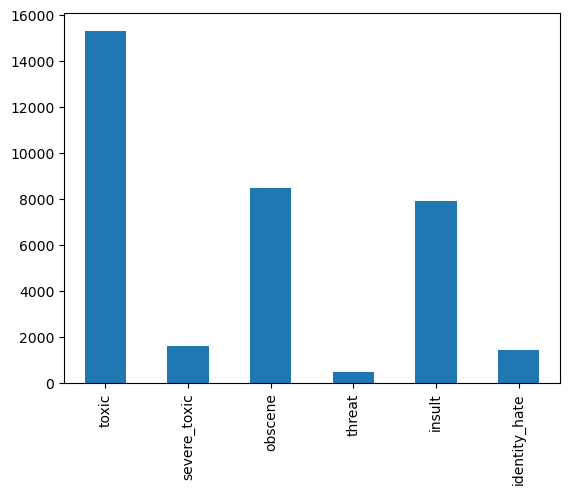

In [9]:
df.plot.bar()

---

### Load word2vec as dictionary

In [10]:
# load in pre-trained word vectors as dict {word:vec}
# will be used later to build our embedding matrix
word2vec = {}
with open(os.path.join("./glove.6B/glove.6B.{}d.txt".format(embedding_size))) as f:
    # a space separated text file in the format:
    # word vec[0] vec[1] vec[2] ... vec[embedding_size]
    for line in f:
        values = line.split()
        word = values[0]
        vec = np.asarray(values[1:],dtype='float32')
        word2vec[word] = vec
print('Found {} word vectors.'.format(len(word2vec)))

Found 400000 word vectors.


In [11]:
print(word2vec.get("man"))
print(len(word2vec.get("man")))
print(word2vec.get("woman"))
print(len(word2vec.get("woman")))

mw=np.dot(word2vec.get("man"),word2vec.get("woman"))
kq=np.dot(word2vec.get("king"),word2vec.get("queen"))

nop=np.dot(word2vec.get("man"),word2vec.get("chair"))

print("man woman: ",mw, "king queen: ",kq, "man chair",nop)

[-0.094386  0.43007  -0.17224  -0.45529   1.6447    0.40335  -0.37263
  0.25071  -0.10588   0.10778  -0.10848   0.15181  -0.65396   0.55054
  0.59591  -0.46278   0.11847   0.64448  -0.70948   0.23947  -0.82905
  1.272     0.033021  0.2935    0.3911   -2.8094   -0.70745   0.4106
  0.3894   -0.2913    2.6124   -0.34576  -0.16832   0.25154   0.31216
  0.31639   0.12539  -0.012646  0.22297  -0.56585  -0.086264  0.62549
 -0.0576    0.29375   0.66005  -0.53115  -0.48233  -0.97925   0.53135
 -0.11725 ]
50
[-1.8153e-01  6.4827e-01 -5.8210e-01 -4.9451e-01  1.5415e+00  1.3450e+00
 -4.3305e-01  5.8059e-01  3.5556e-01 -2.5184e-01  2.0254e-01 -7.1643e-01
  3.0610e-01  5.6127e-01  8.3928e-01 -3.8085e-01 -9.0875e-01  4.3326e-01
 -1.4436e-02  2.3725e-01 -5.3799e-01  1.7773e+00 -6.6433e-02  6.9795e-01
  6.9291e-01 -2.6739e+00 -7.6805e-01  3.3929e-01  1.9695e-01 -3.5245e-01
  2.2920e+00 -2.7411e-01 -3.0169e-01  8.5286e-04  1.6923e-01  9.1433e-02
 -2.3610e-02  3.6236e-02  3.4488e-01 -8.3947e-01 -2.5174e-

In [12]:
print("max sequence length {}".format(max(len(i) for i in sentences))) 
print("min sequence length {}".format(min(len(i) for i in sentences)))

max sequence length 5000
min sequence length 6


---

## Preprocessing of sentences

In [13]:
# convert sentences into integers
tokenizer = Tokenizer(num_words=max_vocab_size)
tokenizer.fit_on_texts(sentences)

sequences = tokenizer.texts_to_sequences(sentences)
# sequences replaces each word in a comment_text by an integer (token) 

In [14]:
print(type(sequences),len(sequences))
print(len(sequences[1]))
print(sequences[1])
train_df['comment_text'][1]

<class 'list'> 159571
17
[52, 2635, 13, 555, 3809, 73, 4556, 2706, 21, 94, 38, 803, 2679, 992, 589, 8377, 182]


"D'aww! He matches this background colour I'm seemingly stuck with. Thanks.  (talk) 21:51, January 11, 2016 (UTC)"

In [15]:
# get word -> integer dict mapping
word2indx = tokenizer.word_index
print("Found {} unique tokens".format(len(word2indx)))

Found 210337 unique tokens


In [16]:
print(word2indx.get('the'))
word2indx

1


{'the': 1,
 'to': 2,
 'of': 3,
 'and': 4,
 'a': 5,
 'you': 6,
 'i': 7,
 'is': 8,
 'that': 9,
 'in': 10,
 'it': 11,
 'for': 12,
 'this': 13,
 'not': 14,
 'on': 15,
 'be': 16,
 'as': 17,
 'have': 18,
 'are': 19,
 'your': 20,
 'with': 21,
 'if': 22,
 'article': 23,
 'was': 24,
 'or': 25,
 'but': 26,
 'page': 27,
 'wikipedia': 28,
 'my': 29,
 'an': 30,
 'from': 31,
 'by': 32,
 'do': 33,
 'at': 34,
 'me': 35,
 'about': 36,
 'so': 37,
 'talk': 38,
 'what': 39,
 'can': 40,
 'there': 41,
 'all': 42,
 'has': 43,
 'will': 44,
 'please': 45,
 'no': 46,
 'would': 47,
 'one': 48,
 'like': 49,
 'just': 50,
 'they': 51,
 'he': 52,
 'which': 53,
 'any': 54,
 'been': 55,
 'should': 56,
 'more': 57,
 'we': 58,
 "don't": 59,
 'some': 60,
 'other': 61,
 'who': 62,
 'here': 63,
 'see': 64,
 'also': 65,
 'his': 66,
 'think': 67,
 'because': 68,
 'know': 69,
 'how': 70,
 'edit': 71,
 'am': 72,
 "i'm": 73,
 'people': 74,
 'why': 75,
 'up': 76,
 'only': 77,
 "it's": 78,
 'out': 79,
 'articles': 80,
 'use': 81,

Padding of sequence on `max_seq_length`.

In [17]:
# pad sequences so that we get a N x T matrix
data = pad_sequences(sequences, maxlen=max_seq_lenght)
print("shape of data tensor ", data.shape)
# it adds a bunch of zeros in the sequence if it is smaller that max_seq_lenght. 
# Notice that the padding indexes starts from 1. zero is reserved for padding.

shape of data tensor  (159571, 100)


In [18]:
print(train_df['comment_text'][1])
print(sequences[1])
data[1]

D'aww! He matches this background colour I'm seemingly stuck with. Thanks.  (talk) 21:51, January 11, 2016 (UTC)
[52, 2635, 13, 555, 3809, 73, 4556, 2706, 21, 94, 38, 803, 2679, 992, 589, 8377, 182]


array([   0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,   52, 2635,   13,  555, 3809,
         73, 4556, 2706,   21,   94,   38,  803, 2679,  992,  589, 8377,
        182], dtype=int32)

In [19]:
# prepare embedding matrix
print("Filling pre-trained embeddings")
num_words = min(max_vocab_size,len(word2indx)+1)
print(num_words)

embedding_matrix = np.zeros((num_words,embedding_size))
for words, i in word2indx.items():
    if i < max_vocab_size:
        embedding_vector = word2vec.get(words) # get the word vector from the pre-trained word2vec
        if embedding_vector is not None:
            embedding_matrix[i] = embedding_vector

print(embedding_matrix.shape)

Filling pre-trained embeddings
20000
(20000, 50)


In [20]:
print(word2indx.get("the"))
print(word2vec.get("the"))
print(embedding_matrix[1])

1
[ 4.1800e-01  2.4968e-01 -4.1242e-01  1.2170e-01  3.4527e-01 -4.4457e-02
 -4.9688e-01 -1.7862e-01 -6.6023e-04 -6.5660e-01  2.7843e-01 -1.4767e-01
 -5.5677e-01  1.4658e-01 -9.5095e-03  1.1658e-02  1.0204e-01 -1.2792e-01
 -8.4430e-01 -1.2181e-01 -1.6801e-02 -3.3279e-01 -1.5520e-01 -2.3131e-01
 -1.9181e-01 -1.8823e+00 -7.6746e-01  9.9051e-02 -4.2125e-01 -1.9526e-01
  4.0071e+00 -1.8594e-01 -5.2287e-01 -3.1681e-01  5.9213e-04  7.4449e-03
  1.7778e-01 -1.5897e-01  1.2041e-02 -5.4223e-02 -2.9871e-01 -1.5749e-01
 -3.4758e-01 -4.5637e-02 -4.4251e-01  1.8785e-01  2.7849e-03 -1.8411e-01
 -1.1514e-01 -7.8581e-01]
[ 4.18000013e-01  2.49679998e-01 -4.12420005e-01  1.21699996e-01
  3.45270008e-01 -4.44569997e-02 -4.96879995e-01 -1.78619996e-01
 -6.60229998e-04 -6.56599998e-01  2.78430015e-01 -1.47670001e-01
 -5.56770027e-01  1.46579996e-01 -9.50950012e-03  1.16579998e-02
  1.02040000e-01 -1.27920002e-01 -8.44299972e-01 -1.21809997e-01
 -1.68009996e-02 -3.32789987e-01 -1.55200005e-01 -2.31309995e-0

## Build the model

In [21]:
# load pre-trained word embeddings into an Embedding layer 
# note we set trainable = False so as to keep embeddings fixed

embedding_layer = Embedding(
    input_dim=num_words, # embedding_matrix.shape[0]
    output_dim=embedding_size, # embedding_matrix.shape[1]
    weights=[embedding_matrix],
    input_length=max_seq_lenght, # how long our sequences are going to be
    trainable=False
)

/Users/brncat/anaconda3/lib/python3.11/site-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


In [22]:
# train a 1D convnet with global maxpoolong

input_ = Input(shape=(max_seq_lenght,))
x = embedding_layer(input_)
x = Conv1D(128,3,activation='relu')(x)
x = MaxPooling1D(3)(x)
x = Conv1D(128,3,activation='relu')(x)
x = MaxPooling1D(3)(x)
x = Conv1D(128,3,activation='relu')(x)
x = GlobalMaxPool1D()(x)
x = Dense(128,activation='relu')(x)
output = Dense(len(labels), activation='sigmoid')(x) # len(labels) = 6

model = Model(input_, output)
model.compile(
    loss='binary_crossentropy',
    optimizer='rmsprop',
    metrics=['accuracy']
)

In [23]:
model.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 100)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ embedding (Embedding)           │ (None, 100, 50)        │     1,000,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d (Conv1D)                 │ (None, 98, 128)        │        19,328 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d (MaxPooling1D)    │ (None, 32, 128)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_1 (Conv1D)               │ (None, 30, 128)        │        49,280 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_1 (MaxPooling1D)  │ (None, 10, 128)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_2 (Conv1D)               │ (None, 8, 128)         │        49,280 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_max_pooling1d            │ (None, 128)            │             0 │
│ (GlobalMaxPooling1D)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │        16,512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 6)              │           774 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,135,174 (4.33 MB)

 Trainable params: 135,174 (528.02 KB)

 Non-trainable params: 1,000,000 (3.81 MB)

In [24]:
r = model.fit(
    data,
    targets,
    batch_size=batch_size,
    epochs=epochs,
    validation_split=0.3
)

Epoch 1/10
873/873 ━━━━━━━━━━━━━━━━━━━━ 17s 19ms/step - accuracy: 0.9382 - loss: 0.1097 - val_accuracy: 0.9940 - val_loss: 0.0855
Epoch 2/10
873/873 ━━━━━━━━━━━━━━━━━━━━ 18s 21ms/step - accuracy: 0.9941 - loss: 0.0722 - val_accuracy: 0.9939 - val_loss: 0.0780
Epoch 3/10
873/873 ━━━━━━━━━━━━━━━━━━━━ 19s 22ms/step - accuracy: 0.9946 - loss: 0.0670 - val_accuracy: 0.9940 - val_loss: 0.0704
Epoch 4/10
873/873 ━━━━━━━━━━━━━━━━━━━━ 20s 22ms/step - accuracy: 0.9937 - loss: 0.0631 - val_accuracy: 0.9932 - val_loss: 0.0672
Epoch 5/10
873/873 ━━━━━━━━━━━━━━━━━━━━ 19s 22ms/step - accuracy: 0.9939 - loss: 0.0575 - val_accuracy: 0.9930 - val_loss: 0.0677
Epoch 6/10
873/873 ━━━━━━━━━━━━━━━━━━━━ 20s 23ms/step - accuracy: 0.9936 - loss: 0.0553 - val_accuracy: 0.9922 - val_loss: 0.0676
Epoch 7/10
873/873 ━━━━━━━━━━━━━━━━━━━━ 19s 22ms/step - accuracy: 0.9932 - loss: 0.0522 - val_accuracy: 0.9933 - val_loss: 0.0702
Epoch 8/10
873/873 ━━━━━━━━━━━━━━━━━━━━ 20s 23ms/step - accuracy: 0.9939 - loss: 0.0490 - 

In [25]:
r.history 

{'accuracy': [0.9806891679763794,
  0.9941449761390686,
  0.9939301013946533,
  0.9939032793045044,
  0.9937958121299744,
  0.9936525821685791,
  0.9933392405509949,
  0.9929900765419006,
  0.9916293025016785,
  0.9909489154815674],
 'loss': [0.08933382481336594,
  0.07141272723674774,
  0.06639790534973145,
  0.062306590378284454,
  0.05905018374323845,
  0.056010447442531586,
  0.05281338095664978,
  0.049690935760736465,
  0.04660221189260483,
  0.04391529783606529],
 'val_accuracy': [0.9940466284751892,
  0.9939004182815552,
  0.9939839839935303,
  0.9932110905647278,
  0.9930439591407776,
  0.9921875,
  0.9933363795280457,
  0.9938586354255676,
  0.9851687550544739,
  0.9876545667648315],
 'val_loss': [0.08553861826658249,
  0.07796777039766312,
  0.0703650489449501,
  0.06719716638326645,
  0.06768178939819336,
  0.06761626154184341,
  0.07023762166500092,
  0.07332205772399902,
  0.07286839187145233,
  0.07453211396932602]}

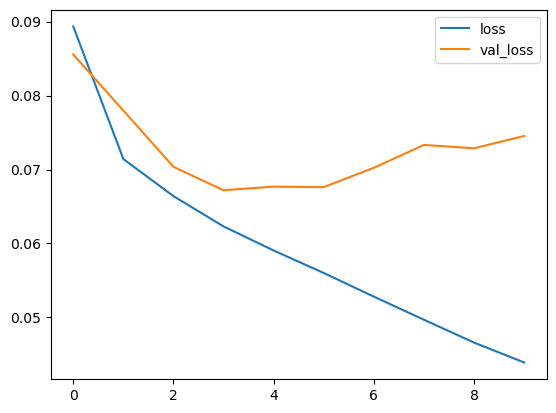

In [26]:
plt.plot(r.history['loss'], label='loss')
plt.plot(r.history['val_loss'], label='val_loss')
plt.legend()
plt.show()

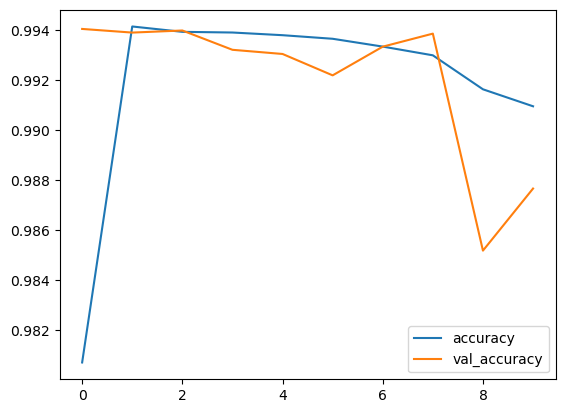

In [27]:
plt.plot(r.history['accuracy'], label='accuracy')
plt.plot(r.history['val_accuracy'], label='val_accuracy')
plt.legend()
plt.show()

In [28]:
# plot the mean AUC over each label

p = model.predict(data)
aucs = []
for j in range(len(labels)):
    auc = roc_auc_score(targets[:,j],p[:,j])
    aucs.append(auc)
print(np.mean(aucs))

4987/4987 ━━━━━━━━━━━━━━━━━━━━ 19s 4ms/step
0.9785111945797066
